In [34]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [62]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 345

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

In [3]:
# Load data
images = np.load("Data/sample_1000_image.npy")
labels = np.load("Data/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# Get "img" data frame and "lbl" series from the df
img = df.iloc[:, 0:-1]
lbl = df['label']
# Split into train, validation and test set
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)
x_train, x_valid, y_train, y_valid = train_test_split(x_train1, y_train1, test_size = 0.2, random_state = 123, stratify = y_train1)

In [6]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(220800, 784)
(55200, 784)
(69000, 784)
(220800,)
(55200,)
(69000,)


In [7]:
# Convert dataframe to tensor
x_train = torch.tensor(x_train.values)
y_train = torch.tensor(y_train.values)

x_valid = torch.tensor(x_valid.values)
y_valid = torch.tensor(y_valid.values)

x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)

In [8]:
# Reshape all tensors to the size of (length, 1, 28, 28)
x_train = x_train.reshape((-1, 1, 28, 28))
x_valid = x_valid.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

In [9]:
# Create dataloaders

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

In [10]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [36]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [37]:

##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Linear(120, 84),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [63]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [64]:
DEVICE

'cuda:0'

In [40]:
def print_sizes(self, input, output):

    print('Inside ' + self.__class__.__name__ + ' forward')
    print('input size:', input[0].size())
    print('output size:', output.data.size())

    
## Debugging


# model.features[0].register_forward_hook(print_sizes)
# model.features[1].register_forward_hook(print_sizes)
# model.features[2].register_forward_hook(print_sizes)
# model.features[3].register_forward_hook(print_sizes)

# model.classifier[0].register_forward_hook(print_sizes)
# model.classifier[1].register_forward_hook(print_sizes)
# model.classifier[2].register_forward_hook(print_sizes)


In [41]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        
        features = features.float()
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [42]:
list_costs = []


In [56]:
list_epochs = np.linspace(0, 49.75, num=200)

In [57]:
list_epochs

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25,
       31.5 , 31.75,

In [65]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.float()
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
            list_costs.append(cost)


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE) ))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 0000/1725 | Cost: 5.8533
Epoch: 001/050 | Batch 0500/1725 | Cost: 4.1213
Epoch: 001/050 | Batch 1000/1725 | Cost: 3.6142
Epoch: 001/050 | Batch 1500/1725 | Cost: 3.1774
Epoch: 001/050 | Train: 32.237% | Validation: 31.486%
Time elapsed: 0.42 min
Epoch: 002/050 | Batch 0000/1725 | Cost: 3.1038
Epoch: 002/050 | Batch 0500/1725 | Cost: 2.8469
Epoch: 002/050 | Batch 1000/1725 | Cost: 2.9034
Epoch: 002/050 | Batch 1500/1725 | Cost: 3.0772
Epoch: 002/050 | Train: 36.986% | Validation: 35.935%
Time elapsed: 0.85 min
Epoch: 003/050 | Batch 0000/1725 | Cost: 2.9982
Epoch: 003/050 | Batch 0500/1725 | Cost: 2.9251
Epoch: 003/050 | Batch 1000/1725 | Cost: 3.0264
Epoch: 003/050 | Batch 1500/1725 | Cost: 2.7475
Epoch: 003/050 | Train: 39.171% | Validation: 38.250%
Time elapsed: 1.27 min
Epoch: 004/050 | Batch 0000/1725 | Cost: 3.1738
Epoch: 004/050 | Batch 0500/1725 | Cost: 2.5967
Epoch: 004/050 | Batch 1000/1725 | Cost: 2.6167
Epoch: 004/050 | Batch 1500/1725 | Cost: 2.4548
E

Epoch: 031/050 | Batch 1500/1725 | Cost: 2.2116
Epoch: 031/050 | Train: 48.127% | Validation: 44.987%
Time elapsed: 13.21 min
Epoch: 032/050 | Batch 0000/1725 | Cost: 2.4378
Epoch: 032/050 | Batch 0500/1725 | Cost: 2.4420
Epoch: 032/050 | Batch 1000/1725 | Cost: 2.2507
Epoch: 032/050 | Batch 1500/1725 | Cost: 1.9704
Epoch: 032/050 | Train: 48.839% | Validation: 45.569%
Time elapsed: 13.63 min
Epoch: 033/050 | Batch 0000/1725 | Cost: 2.4351
Epoch: 033/050 | Batch 0500/1725 | Cost: 2.2192
Epoch: 033/050 | Batch 1000/1725 | Cost: 2.5180
Epoch: 033/050 | Batch 1500/1725 | Cost: 2.5765
Epoch: 033/050 | Train: 49.180% | Validation: 45.746%
Time elapsed: 14.06 min
Epoch: 034/050 | Batch 0000/1725 | Cost: 2.4779
Epoch: 034/050 | Batch 0500/1725 | Cost: 2.3469
Epoch: 034/050 | Batch 1000/1725 | Cost: 2.4196
Epoch: 034/050 | Batch 1500/1725 | Cost: 2.3694
Epoch: 034/050 | Train: 49.587% | Validation: 46.228%
Time elapsed: 14.48 min
Epoch: 035/050 | Batch 0000/1725 | Cost: 2.2654
Epoch: 035/050 |

In [21]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 46.58%


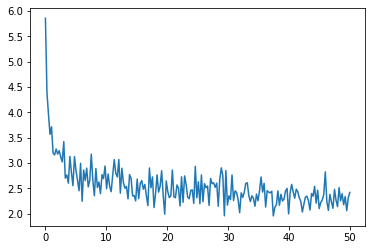

In [25]:
# The plot when lr = 0.0005
plt.plot(list_epochs, list_costs)

In [26]:
# list of costs when lr = 0.0005
list_costs

[tensor(5.8533, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.3932, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.9605, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.5658, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.7140, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.1953, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.1600, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.2770, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.1767, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.2434, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.1238, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.0214, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.4218, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.7045, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.7651, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.6029, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.1298, device='

In [27]:
del(model)

In [28]:
list_costs_1 = list_costs
list_costs = []

In [50]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 42.18%


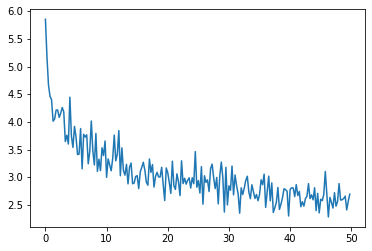

In [58]:
# The plot when lr = 0.0001
plt.plot(list_epochs, list_costs)

In [59]:
list_costs

[tensor(5.8533, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(5.1811, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.6695, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.4622, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.4034, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.0136, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.0521, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.2139, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.2160, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.0820, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.1571, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.2603, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.1815, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.6463, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.7606, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(3.6007, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(4.4462, device='

In [60]:
del(model)

In [61]:
list_costs_2 = list_costs
list_costs = []

In [66]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 46.45%


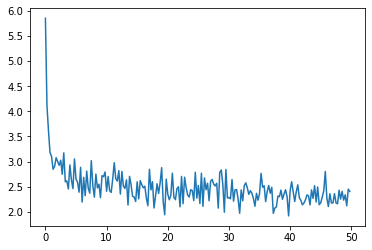

In [67]:
# The plot when lr = 0.0001
plt.plot(list_epochs, list_costs)

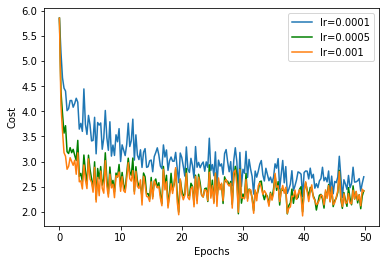

In [81]:
plt.plot(list_epochs, list_costs_2, label='lr=0.0001')
plt.plot(list_epochs, list_costs_1, label='lr=0.0005', color='green')
plt.plot(list_epochs, list_costs, label='lr=0.001')
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend(loc='upper right')
plt.savefig("LeNet5.pdf")
plt.savefig("LeNet5.png")